ElementProperty:   0%|          | 0/9 [00:00<?, ?it/s]

ValenceOrbital:   0%|          | 0/9 [00:00<?, ?it/s]

BandCenter:   0%|          | 0/9 [00:00<?, ?it/s]

Arquivo salvo: metal_features.csv


,metal,Z,Mendeleev,AtomicWeight,Tmelt_K,rcov_A,Electronegativity,val_s_frac,val_p_frac,val_d_frac,val_f_frac,d_band_center
0,(Rh),45.0,59.0,102.905500,2237.00,142.0,2.28,0.111111,0.000000,0.888889,0.000000,4.298300
1,(Ir),77.0,60.0,192.217000,2739.00,141.0,2.20,0.086957,0.000000,0.304348,0.608696,5.343076
2,(Ni),28.0,61.0,58.693400,1728.00,124.0,1.91,0.200000,0.000000,0.800000,0.000000,4.400394
3,(Pd),46.0,62.0,106.420000,1828.05,139.0,2.20,0.000000,0.000000,1.000000,0.000000,4.447036
4,(Pt),78.0,63.0,195.084000,2041.40,136.0,2.28,0.041667,0.000000,0.375000,0.583333,5.572658
5,(Cu),29.0,64.0,63.546000,1357.77,132.0,1.90,0.090909,0.000000,0.909091,0.000000,4.477094
6,(Ag),47.0,65.0,107.868200,1234.93,145.0,1.93,0.090909,0.000000,0.909091,0.000000,4.439262
7,(Au),79.0,66.0,196.966569,1337.33,136.0,2.54,0.040000,0.000000,0.400000,0.560000,5.767517
8,(Pb),82.0,81.0,207.200000,600.61,146.0,2.33,0.071429,0.071429,0.357143,0.500000,3.890444


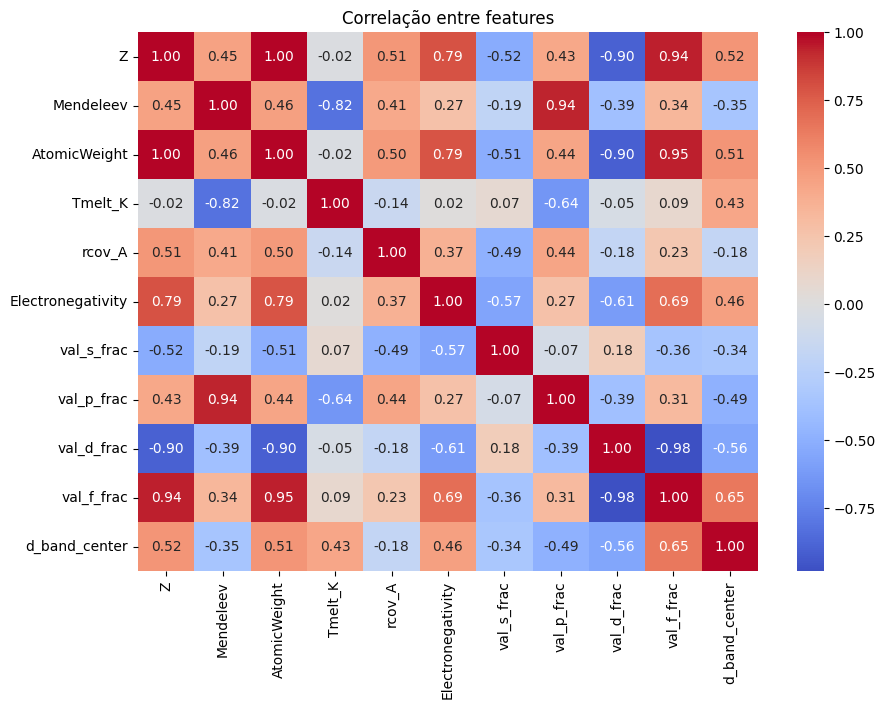

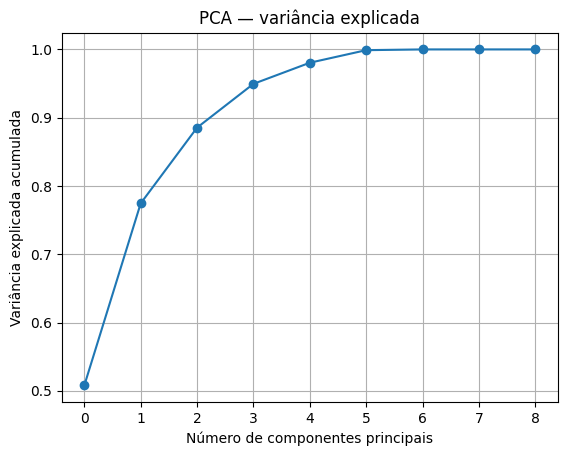

Contribuição das variáveis nas PCs:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Z,0.418175,0.058821,0.003253,0.094259,-0.068217,0.059586,0.605915,0.174219,-0.114134
Mendeleev,0.232615,-0.472338,0.133185,-0.160604,-0.088555,-0.055539,-0.132500,0.680114,0.229450
AtomicWeight,0.418936,0.055362,0.015952,0.086954,-0.073265,0.028390,0.495958,-0.143405,0.117548
Tmelt_K,-0.055517,0.486126,-0.086137,0.570331,0.158707,-0.458191,-0.047462,0.264076,0.181075
rcov_A,0.213978,-0.201605,-0.554905,0.512865,-0.273939,0.428521,-0.281660,-0.055467,0.013801


In [1]:
# Instalar dependências se necessário
# %pip install pymatgen matminer pandas numpy matplotlib seaborn scikit-learn

import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core import Composition

from matminer.featurizers.composition import ElementProperty, ValenceOrbital, BandCenter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")


# =========================================================
# 1) Definir metais da POC
# =========================================================
metals = ["Rh","Ir","Ni","Pd","Pt","Cu","Ag","Au","Pb"]
df = pd.DataFrame({"composition":[Composition(m) for m in metals]})

# =========================================================
# 2) Gerar features com Matminer
# =========================================================
# ElementProperty (preset "magpie") -> Mendeleev, Tmelt, raio covalente, eletronegatividade, etc.
fe_magpie = ElementProperty.from_preset("magpie")
df_mag = fe_magpie.featurize_dataframe(df.copy(), "composition", ignore_errors=True)

# Valence orbitals fractions
fe_val = ValenceOrbital()
df_val = fe_val.featurize_dataframe(df.copy(), "composition", ignore_errors=True)

# d-band center proxy
fe_db = BandCenter()
df_db = fe_db.featurize_dataframe(df.copy(), "composition", ignore_errors=True)

# Unir todos
df_feat = df_mag.join(df_val.drop(columns=["composition"]), how="left")
df_feat = df_feat.join(df_db.drop(columns=["composition"]), how="left")

# =========================================================
# 3) Selecionar subset relevante
# =========================================================
subset_cols = [
    "composition",
    "MagpieData mean Number",          # Z
    "MagpieData mean MendeleevNumber",
    "MagpieData mean AtomicWeight",
    "MagpieData mean MeltingT",
    "MagpieData mean CovalentRadius",
    "MagpieData mean Electronegativity",
    "MagpieData mean ElectronAffinity",
    "frac s valence electrons",
    "frac p valence electrons",
    "frac d valence electrons",
    "frac f valence electrons",
    "band center"
]
subset_cols = [c for c in subset_cols if c in df_feat.columns]
df_sel = df_feat[subset_cols].copy()

# Renomear
rename_map = {
    "composition": "metal",
    "MagpieData mean Number": "Z",
    "MagpieData mean MendeleevNumber": "Mendeleev",
    "MagpieData mean AtomicWeight": "AtomicWeight",
    "MagpieData mean MeltingT": "Tmelt_K",
    "MagpieData mean CovalentRadius": "rcov_A",
    "MagpieData mean Electronegativity": "Electronegativity",
    "MagpieData mean ElectronAffinity": "ElectronAffinity",
    "frac s valence electrons": "val_s_frac",
    "frac p valence electrons": "val_p_frac",
    "frac d valence electrons": "val_d_frac",
    "frac f valence electrons": "val_f_frac",
    "band center": "d_band_center",
}
df_sel.rename(columns=rename_map, inplace=True)

# =========================================================
# 4) Salvar em CSV
# =========================================================
df_sel.to_csv("metal_features.csv", index=False)
print("Arquivo salvo: metal_features.csv")
display(df_sel)

# =========================================================
# 5) Análises de correlação e PCA
# =========================================================
num_cols = [c for c in df_sel.columns if c != "metal"]
X = df_sel[num_cols].to_numpy(dtype=float)

# Heatmap de correlação
plt.figure(figsize=(10,7))
sns.heatmap(df_sel[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlação entre features")
plt.show()

# PCA
X_std = StandardScaler().fit_transform(X)
pca = PCA().fit(X_std)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Número de componentes principais")
plt.ylabel("Variância explicada acumulada")
plt.title("PCA — variância explicada")
plt.grid(True)
plt.show()

loadings = pd.DataFrame(
    pca.components_.T,
    index=num_cols,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print("Contribuição das variáveis nas PCs:")
display(loadings.head())


In [3]:
# Selecionar apenas as colunas escolhidas
final_cols = ["metal", "Mendeleev", "Tmelt_K", "rcov_A", "d_band_center"]
df_final = df_sel[final_cols].copy()

# Conferir resultado
display(df_final)

# Salvar em CSV
df_final.to_csv("metal_features_reduzido.csv", index=False)
print("Dataset reduzido salvo como metal_features_reduzido.csv")


,metal,Mendeleev,Tmelt_K,rcov_A,d_band_center
0,(Rh),59.0,2237.00,142.0,4.298300
1,(Ir),60.0,2739.00,141.0,5.343076
2,(Ni),61.0,1728.00,124.0,4.400394
3,(Pd),62.0,1828.05,139.0,4.447036
4,(Pt),63.0,2041.40,136.0,5.572658
5,(Cu),64.0,1357.77,132.0,4.477094
6,(Ag),65.0,1234.93,145.0,4.439262
7,(Au),66.0,1337.33,136.0,5.767517
8,(Pb),81.0,600.61,146.0,3.890444


Dataset reduzido salvo como metal_features_reduzido.csv
